C:\Users\FREDERICK\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Next 10 Days Predicted Prices:
[63763.617, 65199.164, 65679.875, 64522.39, 63204.336, 61243.695, 59222.395, 56760.984, 54564.047, 52873.418]


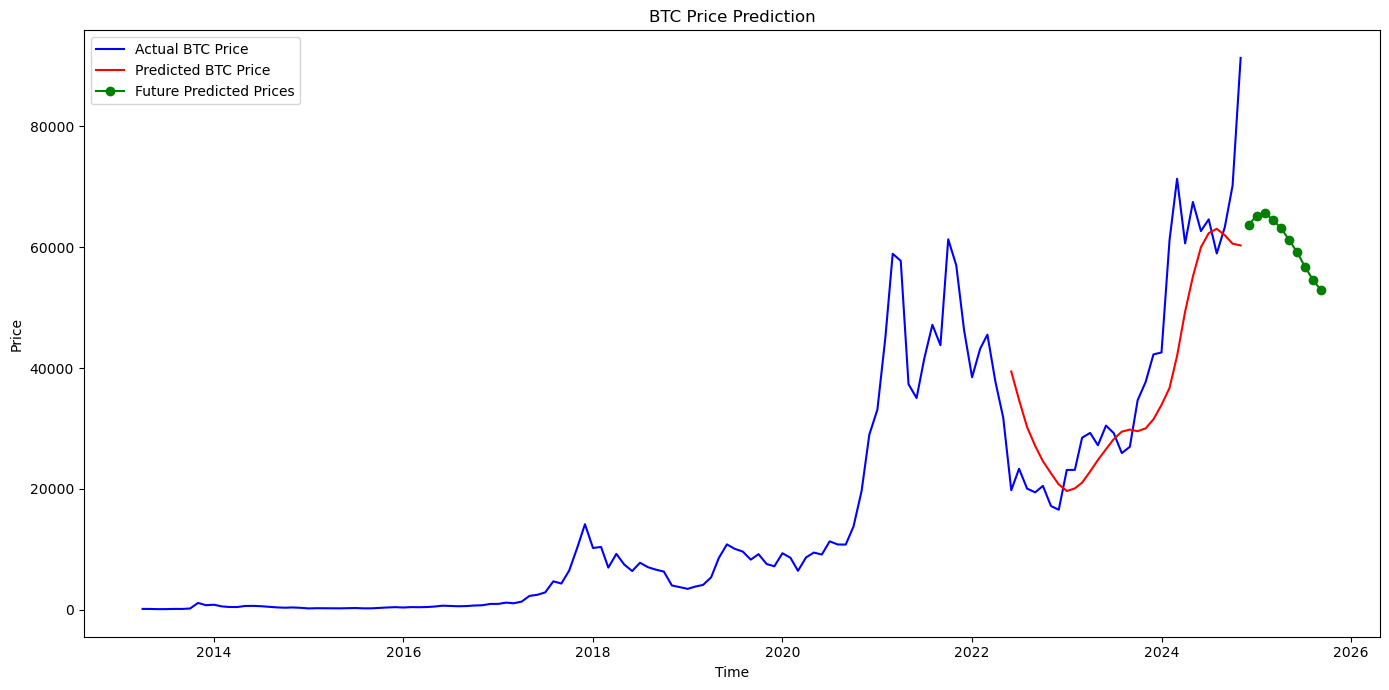

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Step 1: Load Data
# Load the dataset from the specified path
data = pd.read_csv('./data/BTC_All_graph_coinmarketcap.csv', delimiter=';')

# Print sequential time series
time_series = np.arange(1, len(data) + 1)

# Use the 'close' column for prediction
prices = data['close'].values  # Replace 'close' with your actual column name if needed
prices = prices.reshape(-1, 1)

timestamp = data['timestamp'].values 
timestamp = timestamp.reshape(-1, 1)

df = pd.DataFrame(timestamp, columns=['timestamp'])

# Use format='ISO8601' to handle mixed ISO 8601 formats
df['date'] = pd.to_datetime(df['timestamp'], format='ISO8601').dt.date

# Drop the original timestamp column (optional)
df = df.drop(columns=['timestamp'])
times = np.array(df)

# Step 2: Normalize Data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_prices = scaler.fit_transform(prices)

# Step 3: Prepare Data for LSTM
sequence_length = 10
x_train, y_train = [], []

for i in range(sequence_length, len(scaled_prices)):
    x_train.append(scaled_prices[i-sequence_length:i, 0])
    y_train.append(scaled_prices[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

# Step 4: Define the Model
model = Sequential()

# Add LSTM layers
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

# Add Dense layer
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Step 5: Train the Model
model.fit(x_train, y_train, epochs=50, batch_size=32, verbose=0)

# Step 6: Test and Predict
# Prepare test data (similar to training data preparation)
test_data = scaled_prices[-(sequence_length+30):]  # Adjust this based on your dataset
x_test, y_test = [], []

for i in range(sequence_length, len(test_data)):
    x_test.append(test_data[i-sequence_length:i, 0])
    y_test.append(test_data[i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# Make predictions
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Sequential time series for plotting
plot_time_series = time_series[-len(predictions):]
plot_time_stamp = times[-len(predictions):]

# Predict the next 10 days
future_predictions = []
input_sequence = scaled_prices[-sequence_length:]  # Start with the last sequence_length points

for _ in range(10):
    # Reshape input sequence for prediction
    input_sequence_reshaped = input_sequence.reshape(1, sequence_length, 1)
    next_price_scaled = model.predict(input_sequence_reshaped)
    # Append the prediction to the result
    future_predictions.append(scaler.inverse_transform(next_price_scaled)[0, 0])
    # Update input_sequence with the new prediction
    input_sequence = np.append(input_sequence, next_price_scaled)[-sequence_length:]

# Print future predictions
print("Next 10 Days Predicted Prices:")
print(future_predictions)

# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(times, prices, color='blue', label='Actual BTC Price')
plt.plot(plot_time_stamp, predictions, color='red', label='Predicted BTC Price')

# Plot future predictions
future_time_series = np.arange(len(prices) + 1, len(prices) + 11)  # Indices for future prices

df['diff'] = df['date'].diff()
most_common_diff = df['diff'].mode()[0]
last_timestamp = df['date'].iloc[-1]
new_timestamps = [last_timestamp + i * most_common_diff for i in range(1, 11)]

plt.plot(new_timestamps, future_predictions, color='green', marker='o', label='Future Predicted Prices')

plt.title('BTC Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.tight_layout()
plt.show() 

In [12]:
plot_time_stamp = np.array(plot_time_stamp).flatten()
new_timestamps = np.array(new_timestamps)
a = np.concatenate((plot_time_stamp, new_timestamps))

In [13]:
type(predictions)
type(future_predictions)
b = np.concatenate((predictions.flatten(), future_predictions))

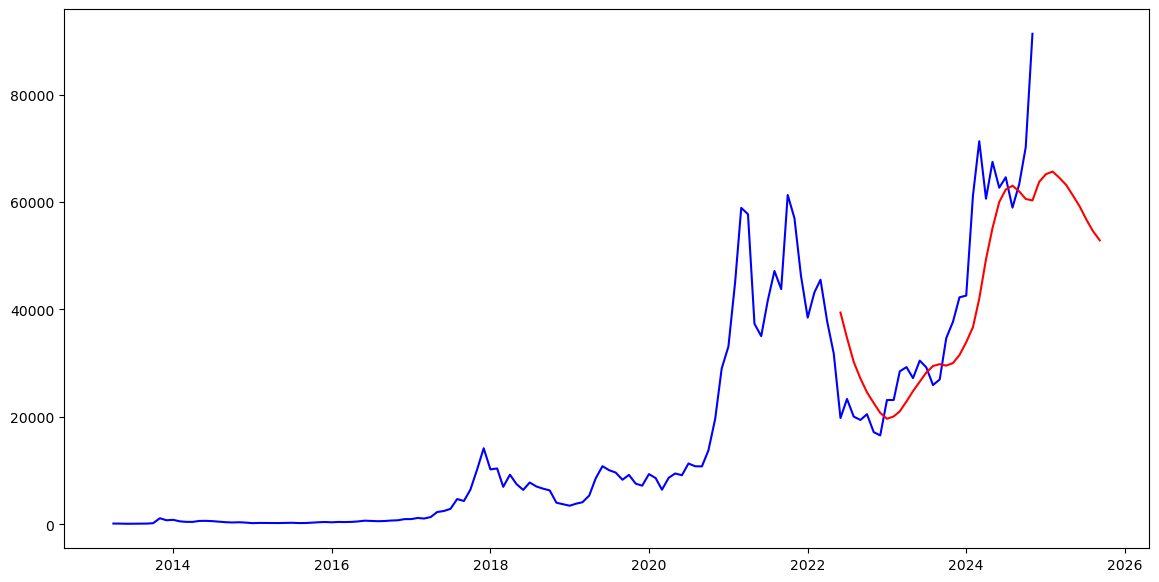

In [14]:
plt.figure(figsize=(14, 7))
plt.plot(times, prices, color='blue', label='Actual BTC Price')
plt.plot(a, b, color='red', label='Future Predicted Prices')

In [15]:
model.save("BTC.h5")

In [21]:
import tensorflow as tf

loaded_model = tf.keras.models.load_model('BTC.h5')

#loaded_model.summary()